# Find MHWs using BATS core data (bottle data)

Things done:

- [x] Looked at both BATs bottle and CTD data
- [x] Used a seasonal threshold for detecting MHWs at surface (top 30m) (2016 was pretty warm)
- [x] Also looked at cold spells and found an event in 2010

Things that need to be improved:

- [ ] Genearly the notebook needs to be improved/cleaned up a bit
- [ ] Some function for processing data. Ideally would call a method that knows how to treat bottle data, CTD, etc.
- [ ] Get clarity on why CTD vs bottle data differ in maximum values so much :( 

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw

from scipy.interpolate import griddata
import matplotlib.colors as mcolors

import scipy.interpolate as spi
import cmocean
import seawater as sw

In [2]:
path = "/home/mtorres4/project/OceanCritters/"

In [3]:
# https://datadocs.bco-dmo.org/file/7DkKkrjTW5K4Pw/3918_v8_bats_ctd.csv
url = "https://datadocs.bco-dmo.org/file/OJRrAA6hpQREv3/3782_v6_bats_bottle.csv"
df = pd.read_csv(url)
df.head(5)

,ISO_DateTime_UTC,Bottle_ID,Latitude,Longitude,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF25_Prochloro,Synechococcus,QF26_Synecho,Picoeukaryotes,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,time,decimal_year
0,1988-10-20T22:30Z,1000100112,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,12,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
1,1988-10-20T22:30Z,1000100111,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,11,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
2,1988-10-20T22:30Z,1000100110,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,10,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
3,1988-10-20T22:30Z,1000100109,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,9,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311
4,1988-10-20T22:30Z,1000100108,31.783,-64.116,R/V Weatherbird I,10001,BATS Core,1,1,8,...,9,NaN,9,NaN,9,NaN,9,19881020,2230,1988.80311


In [12]:
# bottle data
df.Temp.max()

np.float64(32.986)

In [13]:
df['datetime'] = pd.to_datetime(df['ISO_DateTime_UTC'], errors="coerce")#.astype('datetime64[s]')

In [14]:
def make_depth_datasets(df, depths, time='datetime'):
    
    da = {}
    for min_depth, max_depth, label in depths:

        df_subset = df[(df['Depth'] >= min_depth) & (df['Depth'] <= max_depth)].copy()
        
        df_subset['YearMonthDay'] = pd.to_datetime(df_subset[time]).dt.floor('D')
        # df_subset['YearMonth'] = df_subset[time].dt.strftime('%Y-%m')
        df_subset['YearMonth'] = df_subset[time].dt.to_period('M')
        df_subset['Month'] = df_subset[time].dt.month
        df_subset['Year'] = df_subset[time].dt.year
        
        da[label] = df_subset
        
    return da

In [15]:
depth_ranges = [
    (0, 30, 'surf')] #30
da = make_depth_datasets(df, depth_ranges)

In [16]:
da = da["surf"]

In [17]:
da.columns

Index(['ISO_DateTime_UTC', 'Bottle_ID', 'Latitude', 'Longitude', 'Vessel',
       'Cruise_ID', 'Cruise_type', 'Cruise_num', 'Cast_num', 'Bottle_num',
       'QF_bottle', 'Depth', 'QF1_Depth', 'Temp', 'QF2_Temp', 'CTD_Salinity',
       'QF3_CTD_Sal', 'Salinity', 'QF4_Salinity', 'Sigma_theta',
       'QF5_Sigma_theta', 'Oxygen', 'QF6_Oxygen', 'Oxygen_Fix_Temp',
       'QF7_Oxy_fix_temp', 'Oxygen_Anomaly', 'QF8_Oxy_anom', 'CO2', 'QF9_DIC',
       'Alk', 'QF10_Alk', 'NO3_plus_NO2', 'QF11_NO3_NO2', 'NO2', 'QF12_NO2',
       'PO4', 'QF13_PO4', 'Silicate', 'QF14_Silicate', 'POC', 'QF15_POC',
       'PON', 'QF16_PON', 'TOC', 'QF17_TOC', 'TN', 'QF18_TN', 'Bact_Enum',
       'QF19_Bact_enum', 'POP', 'QF20_POP', 'TDP', 'QF21_TDP', 'SRP',
       'QF22_SRP', 'Bio_Si', 'QF23_bio_Si', 'Litho_Si', 'QF24_litho_Si',
       'Prochlorococcus', 'QF25_Prochloro', 'Synechococcus', 'QF26_Synecho',
       'Picoeukaryotes', 'QF27_Picoeuks', 'Nanoeukaryotes', 'QF28_Nanoeuks',
       'yyyymmdd', 'time', 'decimal_

In [18]:
da.drop(columns=['time'], inplace=True)

In [19]:
da.rename(columns={
    "YearMonth": "time",
    "Latitude": "lat",
    "Longitude": "lon",
    "Temp": "temp"
}, inplace=True)
da

,ISO_DateTime_UTC,Bottle_ID,lat,lon,Vessel,Cruise_ID,Cruise_type,Cruise_num,Cast_num,Bottle_num,...,QF27_Picoeuks,Nanoeukaryotes,QF28_Nanoeuks,yyyymmdd,decimal_year,datetime,YearMonthDay,time,Month,Year
12,1988-10-21T04:55Z,1000108112,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,12,...,9,NaN,9,19881021,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988
13,1988-10-21T04:55Z,1000108111,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,11,...,9,NaN,9,19881021,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988
14,1988-10-21T04:55Z,1000108110,31.833,-64.167,R/V Weatherbird I,10001,BATS Core,1,81,10,...,9,NaN,9,19881021,1988.80330,1988-10-21 04:55:00+00:00,1988-10-21 00:00:00+00:00,1988-10,10,1988
24,1988-11-23T14:00Z,1000200112,31.817,-64.183,R/V Weatherbird I,10002,BATS Core,2,1,12,...,9,NaN,9,19881123,1988.89504,1988-11-23 14:00:00+00:00,1988-11-23 00:00:00+00:00,1988-11,11,1988
25,1988-11-23T14:00Z,1000200111,31.817,-64.183,R/V Weatherbird I,10002,BATS Core,2,1,11,...,9,NaN,9,19881123,1988.89504,1988-11-23 14:00:00+00:00,1988-11-23 00:00:00+00:00,1988-11,11,1988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71462,2023-12-14T09:44Z,1041101403,31.176,-64.322,R/V Atlantic Explorer,10411,BATS Core,411,14,3,...,9,NaN,9,20231214,2023.95180,2023-12-14 09:44:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023
71463,2023-12-14T09:44Z,1041101404,31.176,-64.322,R/V Atlantic Explorer,10411,BATS Core,411,14,4,...,9,NaN,9,20231214,2023.95180,2023-12-14 09:44:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023
71484,2023-12-14T15:59Z,1041101501,31.671,-64.167,R/V Atlantic Explorer,10411,BATS Core,411,15,1,...,9,NaN,9,20231214,2023.95251,2023-12-14 15:59:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023
71485,2023-12-14T15:59Z,1041101502,31.671,-64.167,R/V Atlantic Explorer,10411,BATS Core,411,15,2,...,9,NaN,9,20231214,2023.95251,2023-12-14 15:59:00+00:00,2023-12-14 00:00:00+00:00,2023-12,12,2023


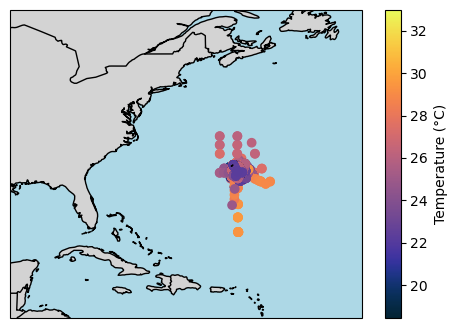

In [20]:
plt.figure(figsize=(6, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

pc = ax.scatter(da["lon"], da["lat"], c=da["temp"], cmap= cmocean.cm.thermal, transform=ccrs.PlateCarree())
plt.colorbar(pc, label= "Temperature (°C)")

ax.set_xlim(-90, -50)
ax.set_ylim(15, 50)

plt.show()

In [21]:
# da["time"] = pd.to_datetime(da["time"])
da["time"] = da["time"].dt.to_timestamp()
da["smooth_temp"] = da["temp"].rolling(window=90, center=True).mean()
da = da.sort_values(by="time")
da = da.drop_duplicates(subset=["time"])
da = da.dropna(subset=["time", "temp"])

da["day_of_year"] = da["time"].dt.month
da["year"] = da["time"].dt.year

time_numeric = da["time"].map(pd.Timestamp.toordinal)
slope, intercept = np.polyfit(time_numeric, da["temp"], 1)
trendline = slope * time_numeric + intercept

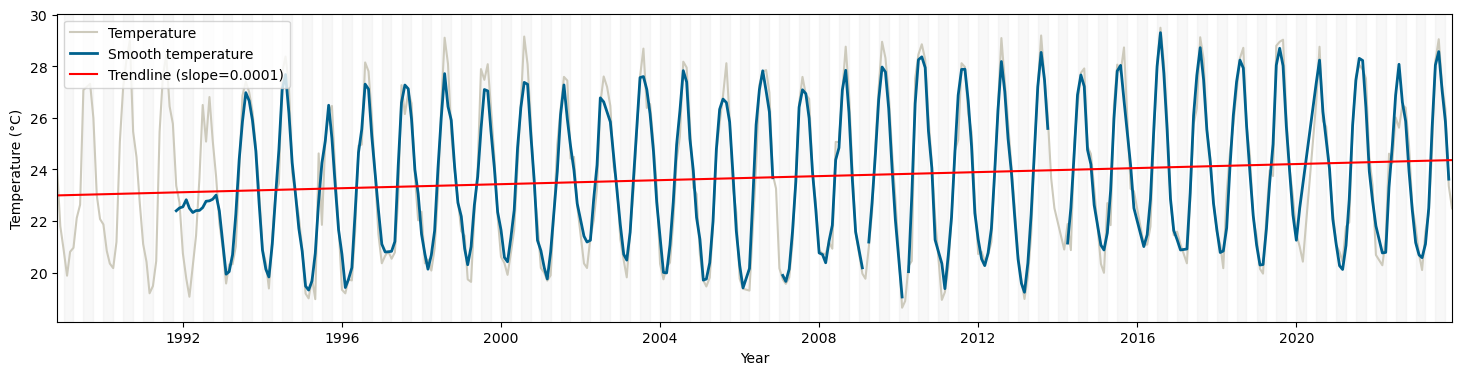

Slope of the trendline: 0.0001
The temperature is increasing over time.


In [22]:
plt.figure(figsize=(18, 4))


for year in range(da["time"].dt.year.min(), da["time"].dt.year.max() + 1):
    for quarter_start, quarter_end in [("01-01", "03-31"), ("04-01", "06-30"), ("07-01", "09-30"), ("10-01", "12-31")]:
        if quarter_start in ["01-01", "07-01"]:
            plt.axvspan(
                pd.Timestamp(f"{year}-{quarter_start}"), pd.Timestamp(f"{year}-{quarter_end}"),
                color="gray", alpha=0.05
            )

plt.plot(da["time"], da["temp"], color="#CDCABC", linewidth=1.5, alpha=1, label="Temperature")
plt.plot(da["time"], da["smooth_temp"], color="#00618D", linewidth=2, label="Smooth temperature")
plt.plot(da["time"], trendline, color="red", label=f"Trendline (slope={slope:.4f})")

plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.xlim(da.time.values[0], da.time.values[-1])
plt.legend()
plt.show()

print(f"Slope of the trendline: {slope:.4f}")
if slope > 0:
    print("The temperature is increasing over time.")
else:
    print("The temperature is decreasing over time.")

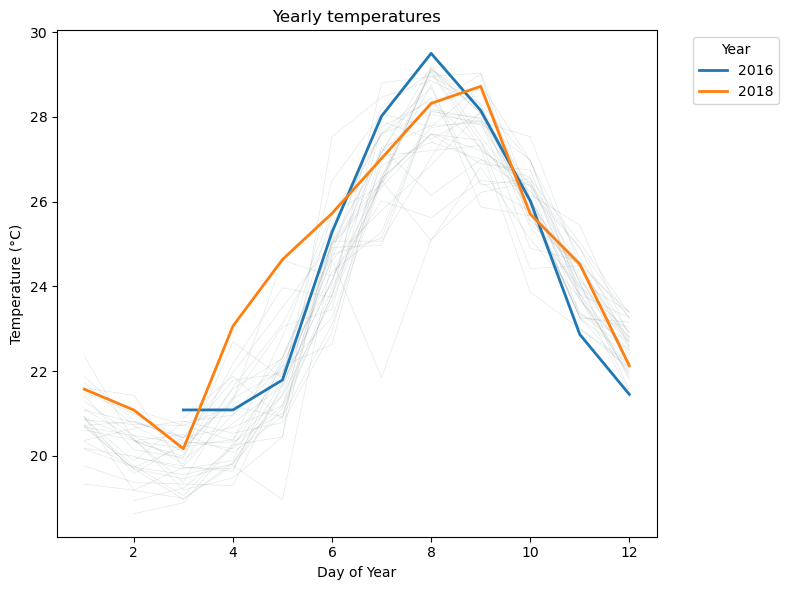

In [23]:
plt.figure(figsize=(8, 6))

for year, group in da.groupby("year"):
    if year in [2016, 2018]:
        plt.plot(group["day_of_year"], group["temp"], label=f"{year}", linewidth=2, alpha=1)
    else:
        plt.plot(group["day_of_year"], group["temp"], color="#4b6669", linewidth=0.5, alpha=0.15)

plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.title("Yearly temperatures")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.xlim(0,360)
plt.tight_layout()
plt.show()

In [25]:
# clim = da.temp.groupby(da.time.dt.dayofyear).mean()
# full_clim_timeseries = da.time.dt.dayofyear.map(clim)
clim = da.temp.groupby(da.time.dt.month).mean()
full_clim_timeseries = da.time.dt.month.map(clim)

da["clim"] = full_clim_timeseries

thresh = da.temp.groupby(da.time.dt.month).quantile(0.90) # you can change the threshold value
full_clim_thresh_timeseries = da.time.dt.month.map(thresh)
da["thresh"] = full_clim_thresh_timeseries

In [26]:
da["Month"] = da["time"].dt.month
da["Year"] = da["time"].dt.year

In [27]:
# Ensure datetime conversion
# da["time"] = pd.to_datetime(da["time"])

# Compute Monthly Climatology
clim = da.groupby("Month")["temp"].mean().reset_index()

# Extend climatology across all years in the dataset
unique_years = da["Year"].unique()
clim_extended = pd.DataFrame({"Month": np.tile(clim["Month"], len(unique_years)),
                              "Year": np.repeat(unique_years, len(clim))})
clim_extended = clim_extended.merge(clim, on="Month", how="left")

# Merge with original dataset to assign climatology
da = da.merge(clim_extended, on=["Year", "Month"], how="left", suffixes=("", "_clim"))

# Assign the extended climatology as 'clim' in da
da["clim"] = da["temp_clim"]
da.drop(columns=["temp_clim"], inplace=True)

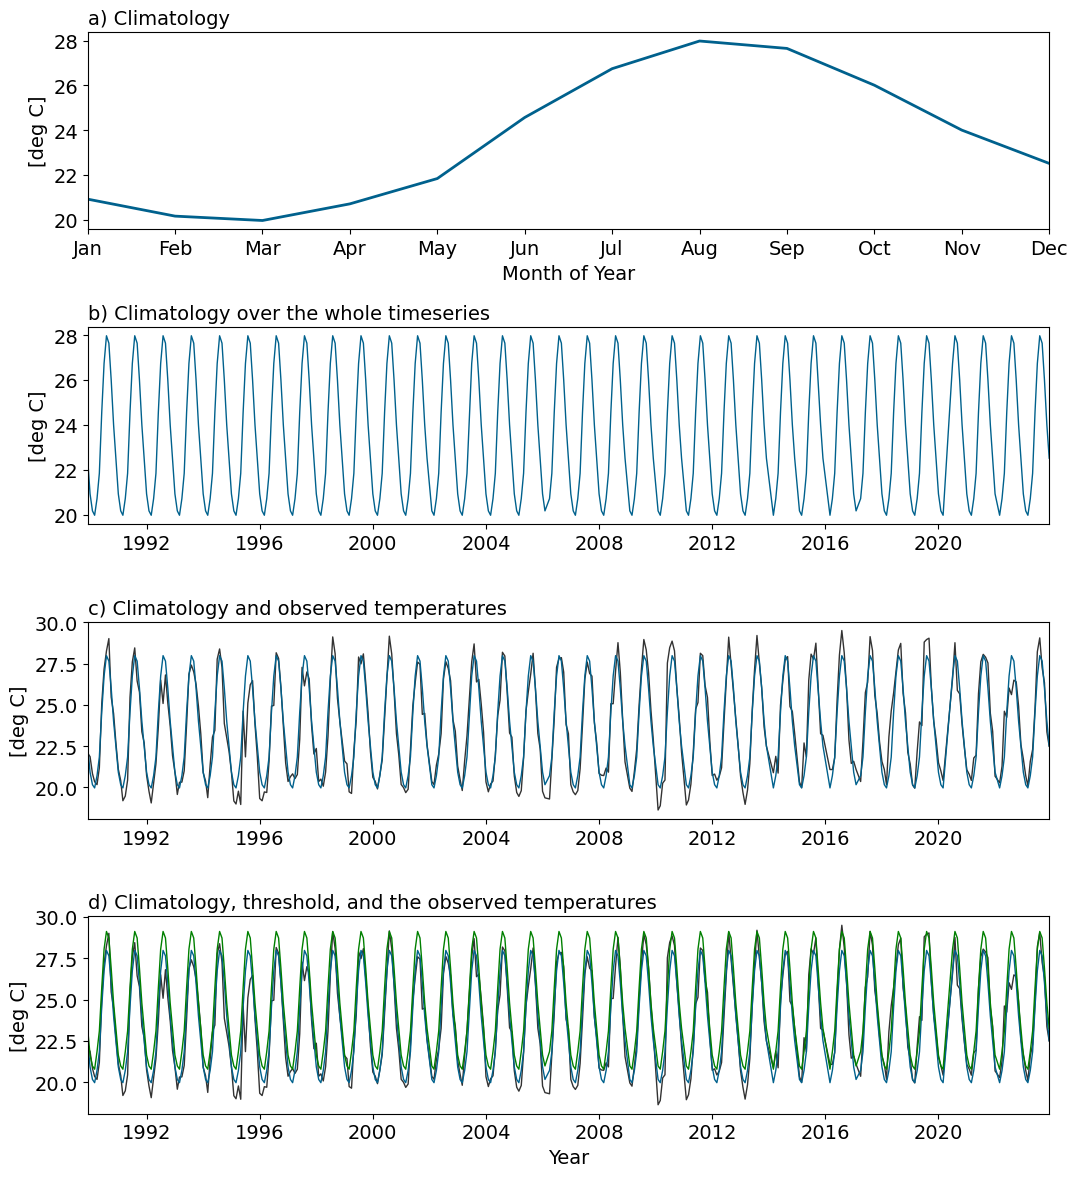

In [28]:
plt.figure(figsize=(11, 12))
plt.rcParams.update({'font.size': 14})
ax1 = plt.subplot(4, 1, 1)
plt.plot(clim["Month"], clim["temp"], color="#00618D", linewidth=2)
plt.xlim(1, 12)
plt.xticks(np.arange(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month of Year")
plt.ylabel("[deg C]")
plt.text(0, 1.04, "a) Climatology", transform=ax1.transAxes, fontsize=14)

ax2 = plt.subplot(4, 1, 2)
plt.plot(da["time"], da["clim"], label="Climatology", color="#00618D", linewidth=1)
plt.xlim(da["time"][12], da["time"].max())
plt.xlabel("")
plt.ylabel("[deg C]")
plt.text(0, 1.04, "b) Climatology over the whole timeseries", transform=ax2.transAxes, fontsize=14)

ax3 = plt.subplot(4, 1, 3)
plt.plot(da["time"], da["temp"], label="Temperature", color="k", linewidth=1,alpha=0.8)
plt.plot(da["time"], da["clim"], label="Climatology", color="#00618D", linewidth=1)
plt.xlim(da["time"][12], da["time"].max())
plt.xlabel("")
plt.ylabel("[deg C]")
# plt.legend()
plt.text(0, 1.04, "c) Climatology and observed temperatures", transform=ax3.transAxes, fontsize=14)

ax4 = plt.subplot(4, 1, 4)
plt.plot(da["time"], da["temp"], label="Temperature", color="k", linewidth=1, alpha=0.8)
plt.plot(da["time"], da["clim"], label="Climatology", color="#00618D", linewidth=1)
plt.plot(da["time"], da["thresh"], label="Threshold", color="g", linewidth=1)
plt.xlim(da["time"][12], da["time"].max())
plt.xlabel("Year")
plt.ylabel("[deg C]")
# plt.legend()
plt.text(0, 1.04, "d) Climatology, threshold, and the observed temperatures", transform=ax4.transAxes, fontsize=14)

plt.tight_layout()
# plt.savefig(f'{path}figures/mhw-workflow-bats.png', dpi=350)
plt.show()

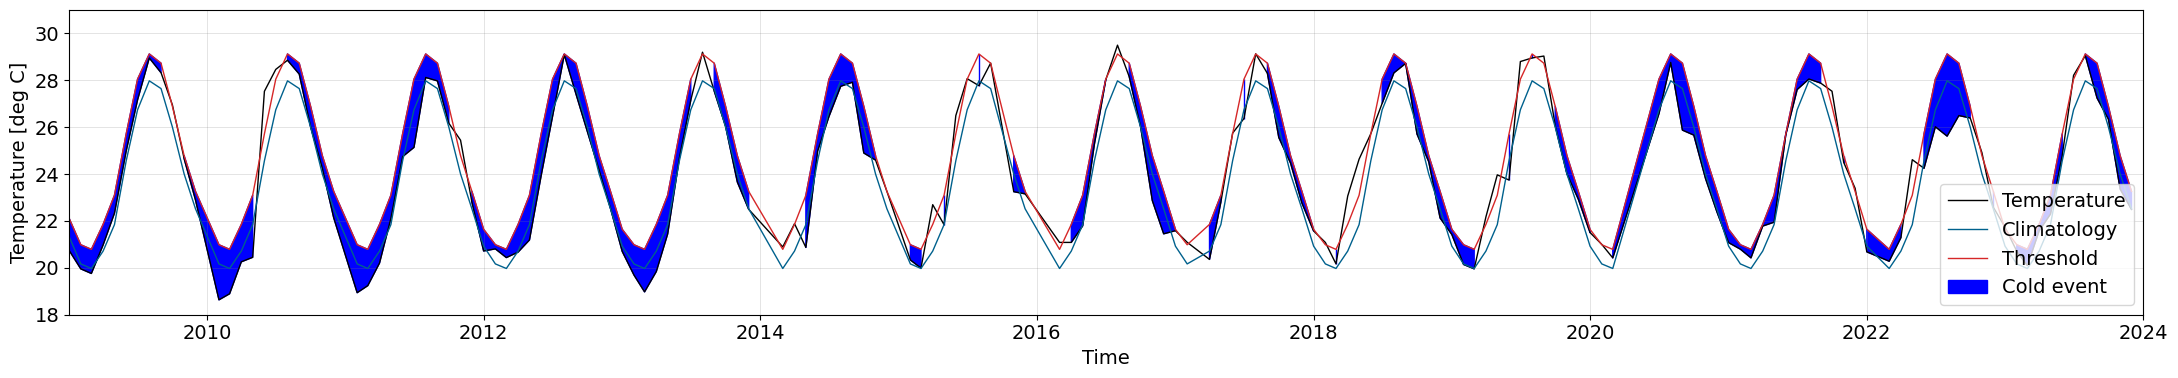

In [29]:
plt.figure(figsize=(22, 4))
plt.rcParams.update({'font.size': 14})
plt.plot(da["time"], da["temp"], label="Temperature", color="k", linewidth=1)
plt.plot(da["time"], da["clim"], label="Climatology", color="#00618D", linewidth=1)
plt.plot(da["time"], da["thresh"], label="Threshold", color="C3",linewidth=1)

# plt.fill_between(
#     da["time"],
#     da["temp"],
#     da["thresh"],
#     where=(da["temp"] > da["thresh"]),
#     color="red",
#     alpha=1,
#     label="Marine Heatwave event"
# )

plt.fill_between(
    da["time"],
    da["temp"],
    da["thresh"],
    where=(da["thresh"] > da["temp"]),
    color="b",
    alpha=1,
    label="Cold event"
)
plt.xlim(da["time"][12], da["time"].max())
# plt.xlim(da["time"].loc[da.time.dt.year == 2010].values[1099],da["time"].loc[da.time.dt.year == 2024].values[-1])
plt.xlim(pd.Timestamp('2009-01-01'), pd.Timestamp('2024-01-01'))
plt.ylim(18,31)
plt.grid(
    which="both",
    linewidth=0.5,
    color='gray',
    alpha=0.3
    )

plt.xlabel("Time")
plt.ylabel("Temperature [deg C]")

plt.legend(loc="lower right", frameon=True)
plt.tight_layout()
# plt.savefig(f'{path}figures/cold-long-bats.png', dpi=350)
plt.show()

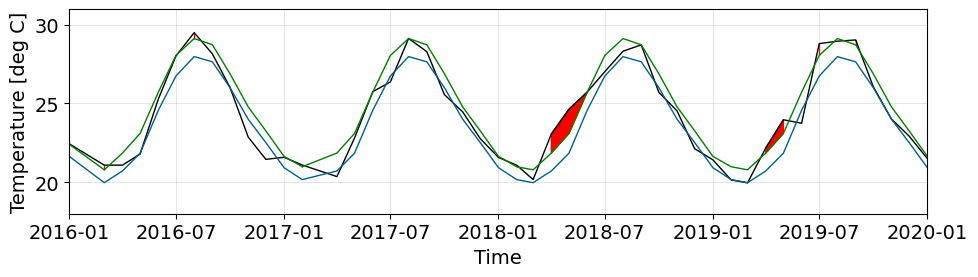

In [124]:
plt.figure(figsize=(10, 3))
plt.rcParams.update({'font.size': 14})
plt.plot(da["time"], da["temp"], label="Temperature", color="k", linewidth=1)
plt.plot(da["time"], da["clim"], label="Climatology", color="#00618D", linewidth=1)
plt.plot(da["time"], da["thresh"], label="Threshold", color="g",linewidth=1)

plt.fill_between(
    da["time"],
    da["temp"],
    da["thresh"],
    where=(da["temp"] > da["thresh"]),
    color="red",
    alpha=1,
    label="Marine Heatwave event"
)

# plt.fill_between(
#     da["time"],
#     da["temp"],
#     da["thresh"],
#     where=(da["thresh"] > da["temp"]),
#     color="b",
#     alpha=1,
#     label="Cold event"
# )
plt.xlim(da["time"][12], da["time"].max())
# plt.xlim(da["time"].loc[da.time.dt.year == 2010].values[1099],da["time"].loc[da.time.dt.year == 2024].values[-1])
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2020-01-01'))
plt.ylim(18,31)
plt.grid(
    which="both",
    linewidth=0.5,
    color='gray',
    alpha=0.3
    )

plt.xlabel("Time")
plt.ylabel("Temperature [deg C]")

# plt.legend(loc="lower left", frameon=True)
plt.tight_layout()
# plt.savefig(f'{path}figures/mhw-short-bats.png', dpi=350)
plt.show()